# Bayesian Semantic Segmentation


### Introduction

Semantic Segmentation has been a challenging task in computer vision and has seen
limited progress till the advent of neural networks (Badrinarayanan et al., 2015). The goal of
semantic segmentation is to label every pixel of an image with a predefined class and this is
useful for object detection, background elimination and for machine learning tasks downstream.
The issue with neural networks for segmentation however is that they are prone to overfitting,
the predictions are not calibrated effectively, the models are highly sensitive to class imbalances
and to minor changes in data distribution during evaluation. We hope to adopt a full Bayesian
approach to semantic segmentation (Badrinarayanan et al., 2016) to alleviate these concerns
leveraging recent developments in probabilistic programming tools like Edward, techniques like
stochastic BBVI together with neural network as function approximators.

![title](img/example.png)

### Need for Bayesian Approach

####  a) Need for clear prediction Uncertainity

MLE estimates combined with Softmax class probabilties do not represent true uncertainity and typically are overconfident of the predictions   (e.g. see Figure 1 for a real world example of pitfalls of overconfident predictions)


![title1](img/crash.jpg)
#### Figure 1.                Tesla  Model S Crash (May 2016) - Perception System confused a white trailer for sky

From Tesla (June 30, 2016)
>  _vehicle was on a divided highway with Autopilot engaged when a tractor trailer drove across the highway perpendicular to the Model S. __Neither Autopilot nor the driver noticed the white side of the tractor trailer against a brightly lit sky, so the brake was not applied__. The high ride height of the trailer combined with its positioning across the road and the extremely rare circumstances of the impact caused the Model S to pass under the trailer, with the bottom of the trailer impacting the windshield of the Model S_

#### b) Handling Out of train distribution

MLE Estimates perform very poorly if the test distribution differs a lot from training distribution. This raises concerns with how automated system will perform as there is no gurantee that a test sample will be close to training distribution (see Figure 2)


![title1](img/test_distrib.png)
#### Figure 2.                Using a Model trained on UK to test a sample from a different country

#### c) Need for probability calibration

For machine learning systems, output of one model needs to be fed to another model. This requires proper calibration of estimates together with associated uncertainity. Car sensor fusion systems combine data from different sensors and modules and when these information is combined, proper claibration is required


#### d) Dealing with class diversity and imbalances
Segmentation tasks deals with huge class imbalances within image with Sky & Road labels occuring 50-300 times more frequently than pedestrian/bikes. Neural networks learn to ignore the smaller classes (various techniques can be used to remedy class imbalance with enough training examples but the problem remains)

## Box's Loop

![title1](img/boxs_loop.png)

### Prior & Current Research

Alex Kendall & Yarin Gal (Cambridge) are the pioneers of Bayesian approach to segmentation (see references) with publications on this since 2016. Their approach is different and they use a technique called Dropout Variational Inference which formulates Dropout technique in Neural Networks (where some neurons are turned off at random) as a form of Bayesian approximation and obtain posterior predictions by not turning off dropout at test time (in NNs, the dropout predictions are averaged to obtain a MLE estimate). They rigorously establish the link between Dropout & Gaussian processes. This helps them leverage the existing NN framework to obtain posterior uncertainity cheaply (no need for VI/MCMC etc)

Our approach is to retain control over modelling and perform a full Bayesian inference with Stochastic VI. This is computationally expensive but gives us more modelling power

## 0. DATA

The data we have chosen is the popular CamVid dataset (Brostow, Shotton, et al., 2008;
Brostow, Fauqueur, & Cipolla, 2008). The dataset contains still images from video footage
from a driving automobile around Cambridge (UK). We will be using a subset of the dataset
rescaled to 360x480 pixels and labels are semantically labeled with 12 classes (Figure3: Sky, Building,
Pole, Road Marking, Road, Pavement, Tree, SignSymbol, Fence, Car, Pedestrian, Bicyclist,
Unlabeled). Due to computational constraints, we rescale the image and labels further to 72x96
pixels. This dataset presents very interesting challenges and relevance to the project because of a)
Lower number of training examples and low resolution b) There is high class imbalance between
categories and low frequency classes are most important for detection tasks (e.g pedestrians
occur 340 times less frequently compared to sky/building) c) There is lot of prior information
structure that can be incorporated in to a Bayesian model d) We can perform interesting criticism on the model and inference

![title1](img/colormap.png)

#### Figure 3 - Output Class 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.misc import imread
import tensorflow as tf
import tensorflow.contrib.slim as slim
from segnet_utils import unpool_with_argmax, get_label_colors, img_annot_to_rgb
from segnet_utils import visualize_image_annot, bayes_visualize_image_annot
from segnet_utils import plot_uncertainity_from_posterior
%matplotlib inline

In [2]:
train_file = 'CamVid/train.txt'
val_file = 'CamVid/val.txt'
test_file = 'CamVid/test.txt'

In [3]:
IMAGE_HEIGHT = 72
IMAGE_WIDTH = 96
IMAGE_DEPTH = 3
NUM_CLASSES = 12
TRAIN_BATCH_SIZE=32
VAL_BATCH_SIZE=TRAIN_BATCH_SIZE
TEST_BATCH_SIZE = TRAIN_BATCH_SIZE
NUM_ITERS = 2000
NUM_TRAIN = 367
NUM_VAL = 101
NUM_TEST = 233

In [4]:
def load_data(file, train=True, batch_size=10, labels=True):
    def _load_image(filename):
        image_string = tf.read_file(filenames[0])
        image_decoded = tf.image.decode_png(image_string, channels=3)
        image_decoded = tf.image.convert_image_dtype(image_decoded,tf.float32)
        return image_decoded

    def _load_image_with_labels(filenames):
        image_string = tf.read_file(filenames[0])
        image_decoded = tf.image.decode_png(image_string, channels=3)
        image_decoded = tf.image.convert_image_dtype(image_decoded,tf.float32)
        image_decoded = tf.image.resize_images(image_decoded,
                                               [IMAGE_HEIGHT, IMAGE_WIDTH])
        annot_string = tf.read_file(filenames[1])
        annot_decoded = tf.image.decode_png(annot_string, channels=1)
        annot_decoded = tf.image.resize_images(annot_decoded,
                                               [IMAGE_HEIGHT,IMAGE_WIDTH])
        annot_decoded = tf.squeeze(annot_decoded,axis=2)
        annot_decoded = tf.cast(annot_decoded, tf.int64)
        return image_decoded, annot_decoded

    dataset = tf.data.Dataset.from_tensor_slices(tf.constant([file]))
    dataset =  dataset.flat_map(lambda filename: tf.data.TextLineDataset(filename))
    dataset = dataset.map(lambda line: tf.string_split([line], delimiter=' ').values)
    if labels:
        dataset = dataset.map(_load_image_with_labels)
    else:
        dataset = dataset.map(_load_image)
    if train is True:
        dataset = dataset.shuffle(buffer_size=batch_size*3)
    dataset = dataset.batch(batch_size=batch_size)
    iterator = dataset.make_initializable_iterator()
    return iterator

In [5]:
tf.reset_default_graph()
train_iterator = load_data(train_file, batch_size=TRAIN_BATCH_SIZE)
val_iterator = load_data(val_file, train=False, batch_size=TRAIN_BATCH_SIZE)
test_iterator = load_data(test_file, train=False, batch_size=TRAIN_BATCH_SIZE)

## Probabilistic Approach

## 1. MODEL

Differing from the Dropout VI approach that formulates Dropout layers as a form of Bayesian
approximation (Badrinarayanan et al., 2016), our approach is to cycle through Box’s loop to
develop models that are less prone to overfitting, incorporate prior information, deal with class
imbalance and produce well calibrated predictions and model uncertainty. Inference though
stochastic methods will be interesting as we encounter convergence issues and hyperparameter
tuning. Criticism is the most interesting part of our analysis for a computer vision task as we as
humans can easily judge whether the prediction uncertainties make sense.

### Bayesian Segmentation Model

Consider dataset of images and associated segment $\{(x_i, y_i)\}$ where $x_i \in \mathbb{R}^{72*96*3}$ and $y_i \in \{0,1,2..11\}^{72*96}$. $x_i$ is a 3 channel RGB image of dimensions 72x96x3 while $y_i$ is an integer bewteen 0 and 11 denoting the pixel wise class labels of dimensions 72x96

The model is given by

$ p(y_i | x_i, w) \sim Categorical(logits=CNN(x_i;w))$

where w are the convolutional weights for all layers defined in the convolutional neural network architecture

$ p(w) \sim StudentT(loc=0, scale=1, dof=1) $

The parameters of this model will be estimated with an Normal approximating distribution (see Inference section below)


The architecture of CNN is provided below


### Figure 3 Convolutional Net Structure

![title](img/conv_net2.png)


In [6]:
import edward as ed
from edward.models import Categorical, Normal, Empirical, StudentT

In [7]:
inputs = tf.placeholder(tf.float32, [TRAIN_BATCH_SIZE, IMAGE_HEIGHT,
                                     IMAGE_WIDTH, IMAGE_DEPTH ])
labels = tf.placeholder(tf.int32,[TRAIN_BATCH_SIZE, IMAGE_HEIGHT, IMAGE_WIDTH])
is_training = tf.placeholder(tf.bool)

In [8]:
def model(inputs_, is_training):
    conv1_w = StudentT(loc=tf.zeros([3,3,3,64]), scale=tf.ones([3,3,3,64]),df=1.0)
    conv1_b = StudentT(loc=tf.zeros([64]), scale=tf.ones([64]),df=1.0)
    net = tf.nn.conv2d(inputs,conv1_w, strides=[1,1,1,1], padding='SAME')
    net = net + conv1_b
    net = tf.contrib.layers.batch_norm(net, is_training=is_training, decay=0.99)
    net = tf.nn.relu(net)
    net, arg1 = tf.nn.max_pool_with_argmax(net, ksize=[1, 2, 2, 1], 
                                           strides=[1, 2, 2, 1], padding='SAME')

    
    conv2_w = StudentT(loc=tf.zeros([3,3,64,128]), scale=tf.ones([3,3,64,128]),df=1.0)
    conv2_b = StudentT(loc=tf.zeros([128]), scale=tf.ones([128]),df=1.0)
    net = tf.nn.conv2d(net,conv2_w, strides=[1,1,1,1], padding='SAME')
    net = net + conv2_b
    net = tf.contrib.layers.batch_norm(net, is_training=is_training, decay=0.99)
    net = tf.nn.relu(net)
    net, arg2 = tf.nn.max_pool_with_argmax(net, ksize=[1, 2, 2, 1], 
                                           strides=[1, 2, 2, 1], padding='SAME')
    
    conv3_w = StudentT(loc=tf.zeros([3,3,128,256]), scale=tf.ones([3,3,128,256]),df=1.0)
    conv3_b = StudentT(loc=tf.zeros([256]), scale=tf.ones([256]),df=1.0)
    net = tf.nn.conv2d(net,conv3_w, strides=[1,1,1,1], padding='SAME')
    net = net + conv3_b
    net = tf.contrib.layers.batch_norm(net, is_training=is_training, decay=0.99)
    net = tf.nn.relu(net)
    net, arg3 = tf.nn.max_pool_with_argmax(net, ksize=[1, 2, 2, 1],
                                           strides=[1, 2, 2, 1], padding='SAME')

    net = unpool_with_argmax(net, arg3, name='maxunpool_arg3')
    conv3r_w = StudentT(loc=tf.zeros([3,3,256,128]), scale=tf.ones([3,3,256,128]),df=1.0)
    conv3r_b = StudentT(loc=tf.zeros([128]), scale=tf.ones([128]),df=1.0)
    net = tf.nn.conv2d(net,conv3r_w, strides=[1,1,1,1], padding='SAME')
    net = net + conv3r_b
    net = tf.contrib.layers.batch_norm(net, is_training=is_training, decay=0.99)
    net = tf.nn.relu(net)
    
    net = unpool_with_argmax(net, arg2, name='maxunpool_arg2')
    conv2r_w = StudentT(loc=tf.zeros([3,3,128,64]), scale=tf.ones([3,3,128,64]),df=1.0)
    conv2r_b = StudentT(loc=tf.zeros([64]), scale=tf.ones([64]),df=1.0)
    net = tf.nn.conv2d(net,conv2r_w, strides=[1,1,1,1], padding='SAME')
    net = net + conv2r_b
    net = tf.contrib.layers.batch_norm(net, is_training=is_training, decay=0.99)
    net = tf.nn.relu(net)
    
    net = unpool_with_argmax(net, arg1, name='maxunpool_arg1')
    conv1r_w = StudentT(loc=tf.zeros([3,3,64,NUM_CLASSES]), 
                        scale=tf.ones([3,3,64,NUM_CLASSES]),df=1.0)
    conv1r_b = StudentT(loc=tf.zeros([NUM_CLASSES]), scale=tf.ones([NUM_CLASSES]),df=1.0)
    net = tf.nn.conv2d(net,conv1r_w, strides=[1,1,1,1], padding='SAME')
    net = net + conv1r_b
    
    predicted_mask = Categorical(logits=net)
    
    conv3_qw = Normal(loc=tf.Variable(tf.random_normal([3,3,128,256])), 
                      scale=tf.nn.softplus(tf.Variable(tf.random_normal([3,3,128,256]))))
    conv3_qb = Normal(loc=tf.Variable(tf.random_normal([256])),
                          scale=tf.nn.softplus(tf.Variable(tf.random_normal([256]))))
    
    conv3r_qw = Normal(loc=tf.Variable(tf.random_normal([3,3,256,128])), 
                      scale=tf.nn.softplus(tf.Variable(tf.random_normal([3,3,256,128]))))
    conv3r_qb = Normal(loc=tf.Variable(tf.random_normal([128])),
                          scale=tf.nn.softplus(tf.Variable(tf.random_normal([128]))))
    
    conv2_qw = Normal(loc=tf.Variable(tf.random_normal([3,3,64,128])), 
                      scale=tf.nn.softplus(tf.Variable(tf.random_normal([3,3,64,128]))))
    conv2_qb = Normal(loc=tf.Variable(tf.random_normal([128])),
                          scale=tf.nn.softplus(tf.Variable(tf.random_normal([128]))))

    conv2r_qw = Normal(loc=tf.Variable(tf.random_normal([3,3,128,64])), 
                      scale=tf.nn.softplus(tf.Variable(tf.random_normal([3,3,128,64]))))
    conv2r_qb = Normal(loc=tf.Variable(tf.random_normal([64])),
                          scale=tf.nn.softplus(tf.Variable(tf.random_normal([64]))))
    
    conv1_qw = Normal(loc=tf.Variable(tf.random_normal([3,3,3,64])), 
                      scale=tf.nn.softplus(tf.Variable(tf.random_normal([3,3,3,64]))))
    conv1_qb = Normal(loc=tf.Variable(tf.random_normal([64])),
                          scale=tf.nn.softplus(tf.Variable(tf.random_normal([64]))))

    conv1r_qw = Normal(loc=tf.Variable(tf.random_normal([3,3,64,NUM_CLASSES])), 
                      scale=tf.nn.softplus(tf.Variable(tf.random_normal([3,3,64,NUM_CLASSES]))))
    conv1r_qb = Normal(loc=tf.Variable(tf.random_normal([NUM_CLASSES])),
                          scale=tf.nn.softplus(tf.Variable(tf.random_normal([NUM_CLASSES]))))
    
    
    latent_dict = {conv1_w: conv1_qw, conv1_b: conv1_qb, 
                   conv1r_w:conv1r_qw, conv1r_b: conv1r_qb,
                   conv2_w: conv2_qw, conv2_b: conv2_qb, 
                   conv2r_w:conv2r_qw, conv2r_b: conv2r_qb,
                   conv3_w: conv3_qw, conv3_b: conv3_qb, 
                   conv3r_w:conv3r_qw, conv3r_b: conv3r_qb
                  }
    
    return predicted_mask, latent_dict

predicted_mask, latent_dict = model(inputs, is_training)

## 2. INFERENCE

Our inference procedure uses BBVI to approximate the posterior distribution of the latent parameters, namely the weights and biases on the convolutional layers. The actual procedure is the following:

    1. In edward, create a KLQP object using the latent variables. Provide number of iters, number of latent variable samples, and scale the samples by N/M so it's as if the algorithm sees N/M training examples per iteration. N is the Number of Training Examples, M is the Batch Size. 
    2. Initialize all edward/tf variables including tf iterators
    3. Get train_image/train_label "pairs" for batch 
    4. Run variational inference with the Kullback-Leibler divergence (KLQP). The P distribution is a Student T as discussed before, the Q distribution is a Normal. We use 5 latent variable samples for computing  black box stochastic gradients in the algorithm
    5. Track loss



In [9]:
predicted_mask

<ed.RandomVariable 'Categorical/' shape=(32, 72, 96) dtype=int32>

In [10]:
def inference(predicted_mask, latent_dict, labels, n_epoch=225,
              session_dir='tmp/inference',restore_sess=False):
    
    N = NUM_TRAIN
    M = TRAIN_BATCH_SIZE
    n_batch=int(N/M)
    loss = []
    if restore_sess:
        sess = ed.get_session()
        saver = tf.train.Saver()
        saver.restore(sess, session_dir)
        return
    else:
        inference = ed.KLqp(latent_dict, data={predicted_mask: labels})
        inference.initialize(n_iter=n_batch*n_epoch, n_samples=5,
                             scale={predicted_mask: N/M})
        saver = tf.train.Saver()
        sess = ed.get_session()
        sess.run(tf.global_variables_initializer())
        sess.run(train_iterator.initializer)
        for i in range(inference.n_iter):
            train_image, train_labels =sess.run(train_iterator.get_next())
            if len(train_image) < TRAIN_BATCH_SIZE:
                sess.run(train_iterator.initializer)
                train_image, train_labels =sess.run(train_iterator.get_next())
            info_dict = inference.update({inputs: train_image, 
                                          labels: train_labels, 
                                          is_training: True})
            inference.print_progress(info_dict)
            loss.append(info_dict['loss'])
        saver.save(sess, session_dir)
        loss = np.array(loss)
        plt.plot(loss[10:])

In [11]:
latent_dict

{<ed.RandomVariable 'StudentT_1/' shape=(64,) dtype=float32>: <ed.RandomVariable 'Normal_9/' shape=(64,) dtype=float32>,
 <ed.RandomVariable 'StudentT_10/' shape=(3, 3, 64, 12) dtype=float32>: <ed.RandomVariable 'Normal_10/' shape=(3, 3, 64, 12) dtype=float32>,
 <ed.RandomVariable 'StudentT_5/' shape=(256,) dtype=float32>: <ed.RandomVariable 'Normal_1/' shape=(256,) dtype=float32>,
 <ed.RandomVariable 'StudentT_6/' shape=(3, 3, 256, 128) dtype=float32>: <ed.RandomVariable 'Normal_2/' shape=(3, 3, 256, 128) dtype=float32>,
 <ed.RandomVariable 'StudentT_3/' shape=(128,) dtype=float32>: <ed.RandomVariable 'Normal_5/' shape=(128,) dtype=float32>,
 <ed.RandomVariable 'StudentT_7/' shape=(128,) dtype=float32>: <ed.RandomVariable 'Normal_3/' shape=(128,) dtype=float32>,
 <ed.RandomVariable 'StudentT_4/' shape=(3, 3, 128, 256) dtype=float32>: <ed.RandomVariable 'Normal/' shape=(3, 3, 128, 256) dtype=float32>,
 <ed.RandomVariable 'StudentT_9/' shape=(64,) dtype=float32>: <ed.RandomVariable 'Nor

2472/2475 [ 99%] █████████████████████████████  ETA: 6s | Loss: 1149533.375 

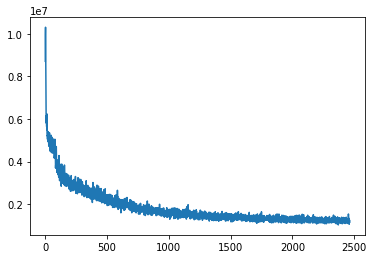

In [12]:
inference(predicted_mask, latent_dict, labels,
          session_dir='checkpoints/new_checkpoint',restore_sess=False)

In [13]:
# inference(predicted_mask, latent_dict, labels,session_dir='checkpoints/checkpoint_final',restore_sess=True)

## 3. CRITICISM

In computer vision tasks, model criticism is a very natural thing. As we can visually observe the output and compare with our own ideas of the world to determine whether the model is "good" representation or not. This is similar to how we run Posterior Predictive Checks and compare the plots of the PPC to the original data as a subjective measure of fit. 

The figure below is an example output from our model 

    1.) The top left image is the actual image which is reduced down from it's original size to 72x96x3
    2.) The top center image is our segmentation 
    3.) The top right image is the true segmentation
    4.) The bottom image is our uncertainity heatmap 

As we can see from this example our model (top center) fails to predict the cyclist which can be seen in the original image and in the true segmentation (top right) as the light blue outline. However one thing to note is that the region containing the cyclist in the true segmentation, around 15-20 on the x-axis and 30-70 on the y-axis, has a high level of uncertainity in our heatmap. Meaning that our model is quite unsure about that region in particular and is quantifying its uncertainity which is exactly what we want.

Another noteworthy finding is that in the true segmentation  around 75 on the x-axis and 20 on the y-axis we have a tree in front of a building. In the labeled true segementation there is some arbitrary distinction between where the tree ends and the building begins with the labeler just marking the whole area as a tree. In our segmentation there is a blending of sorts between the two as if you look in the original image it's possible to see both the tree and the bulding at the same time. Lastly, the uncertainity heat map in that region we have high levels of uncertainity as it's unsure of whether to classify it as a building or a tree.

![title](img/criticism_ex.PNG)


![title](img/viridis.PNG)


In [14]:
def criticism(predicted_mask, latent_dict, data_iterator, num_samples, ppc_nsamples=100,
              plot_one_batch_only = False, plot_random_index_per_batch=False):
    predicted_mask_post = ed.copy(predicted_mask, latent_dict)
    predicted_mask_post_samples = predicted_mask_post.sample(ppc_nsamples)
    sess = ed.get_session()
    sess.run(data_iterator.initializer)
    num_batches = num_samples // TRAIN_BATCH_SIZE
    for i in range(num_batches):
        images, labels = sess.run(data_iterator.get_next())
        ppc=sess.run(predicted_mask_post_samples,
                 feed_dict={inputs: images, predicted_mask: labels, is_training: True})
        
        if plot_random_index_per_batch:
            idx = np.random.choice(TRAIN_BATCH_SIZE,size=1)[0]
            print(idx)
            fig, ax = plt.subplots(1,3,figsize=(10,12))
            for j in range(ppc_nsamples):
                bayes_visualize_image_annot(images[idx],
                                            labels[idx],ppc[j,idx],ax,
                                            n_samples=ppc_nsamples)
            plot_uncertainity_from_posterior(ppc,idx,ppc_nsamples)
        else:
            for idx in range(TRAIN_BATCH_SIZE):
                fig, ax = plt.subplots(1,3,figsize=(10,12))
                for j in range(ppc_nsamples):
                    bayes_visualize_image_annot(images[idx], labels[idx],
                                                ppc[j,idx],ax,
                                                n_samples=ppc_nsamples)
                plot_uncertainity_from_posterior(ppc,idx,ppc_nsamples)
        if plot_one_batch_only:
            break

In [15]:
def selected_criticism(predicted_mask, latent_dict, data_iterator,
                       num_samples, ppc_nsamples=100,
                       plot_one_batch_only = False,
                       plot_random_index_per_batch=False,idx_to_show=[11,12,13]):
    predicted_mask_post = ed.copy(predicted_mask, latent_dict)
    predicted_mask_post_samples = predicted_mask_post.sample(ppc_nsamples)
    sess = ed.get_session()
    sess.run(data_iterator.initializer)
    num_batches = num_samples // TRAIN_BATCH_SIZE
    for i in range(num_batches):
        images, labels = sess.run(data_iterator.get_next())
        ppc=sess.run(predicted_mask_post_samples,
                 feed_dict={inputs: images, predicted_mask: labels, is_training: True})
        
        if plot_random_index_per_batch:
            idx = np.random.choice(TRAIN_BATCH_SIZE,size=1)[0]
            print(idx)
            fig, ax = plt.subplots(1,3,figsize=(10,12))
            for j in range(ppc_nsamples):
                bayes_visualize_image_annot(images[idx],labels[idx],
                                            ppc[j,idx],ax, 
                                            n_samples=ppc_nsamples)
            plot_uncertainity_from_posterior(ppc,idx,ppc_nsamples)
        else:
            if len(idx_to_show) == 0:                
                for idx in range(TRAIN_BATCH_SIZE):
                    fig, ax = plt.subplots(1,3,figsize=(10,12))
                    for j in range(ppc_nsamples):
                        bayes_visualize_image_annot(images[idx],labels[idx],
                                                    ppc[j,idx],ax,
                                                    n_samples=ppc_nsamples)
                    plot_uncertainity_from_posterior(ppc,idx,ppc_nsamples)
            else:
                for idx in idx_to_show:
                    print('picture {}'.format(idx))
                    fig, ax = plt.subplots(1,3,figsize=(20,15))
                    for j in range(ppc_nsamples):
                        bayes_visualize_image_annot(images[idx],labels[idx],
                                                    ppc[j,idx],ax,
                                                    n_samples=ppc_nsamples)
                    plot_uncertainity_from_posterior(ppc,idx,ppc_nsamples)

        if plot_one_batch_only:
            break

Here's we extend the example of a to a frame before and after the image we just discussed. In the firt set of images (picture 11) The cyclist is right beside the car as you can see from the original image and true segmentation in the region [x = 0 to 5,y = 20 to 70]. Our model fails to find the cyclist but instead blends the surroundings i.e. it says this region has some blend of trees at the top, buildings in the middle, and road/sidewalk at the bottom. However, thanks to our models ability to quantify uncertainty we can see that in this region it is quite uncertain about what is there. 

In the next picture (picture 12) as the cyclist has moved down our field of view (now in the region [x = 15 to 20, y = 30 to 70] notice how the "blob" of uncertainity gets brighter and seems to have moved not only in the x direction but also adjusted itself in the y direction. As the cyclist moved the blob of uncertainty seems to have followed.

Finally, in the last set of images the cyclist is almost gone from our field of view, but his new region is still that of high unceratinty as he moves through the frame so does our uncertainty "blob".



picture 11


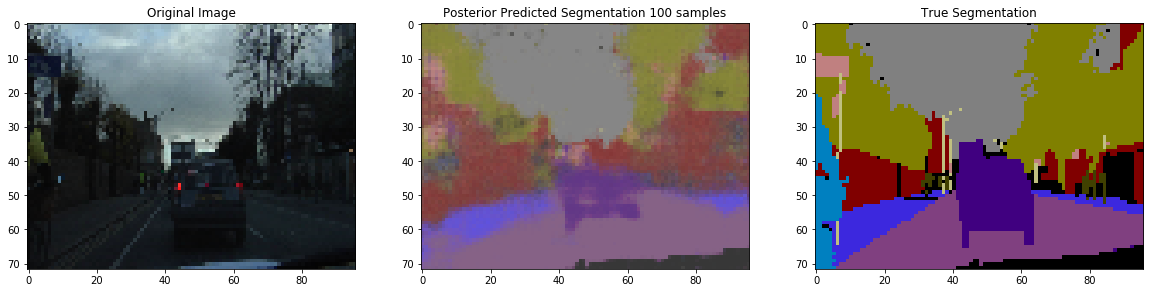

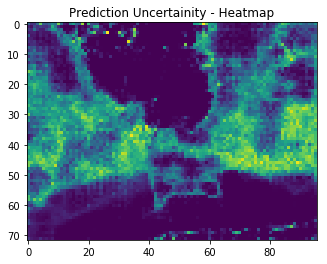

picture 12


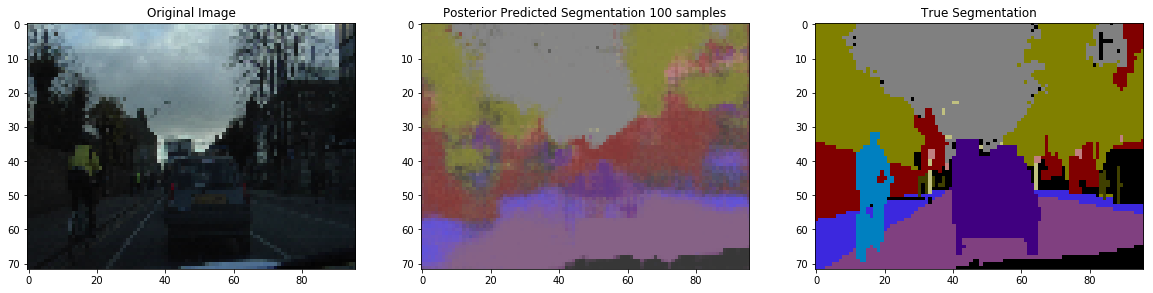

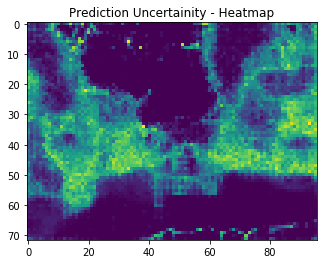

picture 13


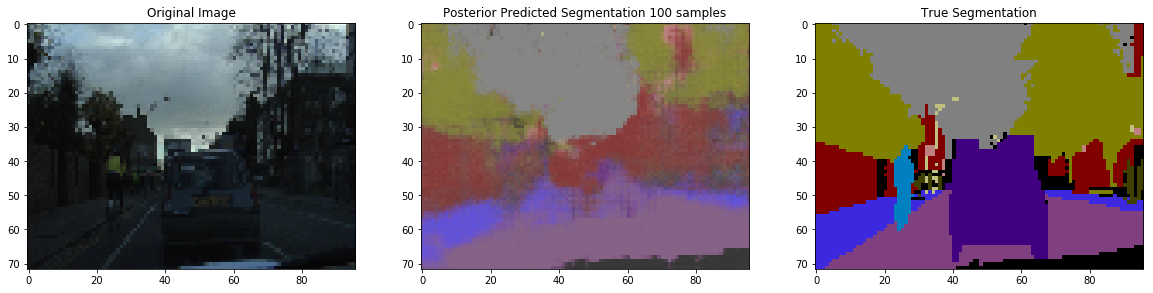

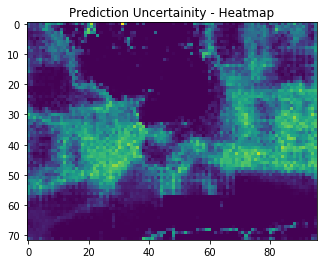

In [16]:
# criticism(predicted_mask, latent_dict, test_iterator,NUM_TEST, plot_one_batch_only=True, 
#          plot_random_index_per_batch=False)

selected_criticism(predicted_mask, latent_dict, test_iterator,NUM_TEST,
                   plot_one_batch_only=True,
                   plot_random_index_per_batch=False,idx_to_show=[11,12,13])


## 4.  CHALLENGES AND LIMITATIONS

We met many challenges during the developement of this project. Mainly surrounding inference, we experimented with different inference algorithms including SGLD and KLQP. We also tried different priors distributions such as standard Normals, Normals with higher variance, etc. but nothing worked quite as well as the Student-T. There are also some limitations as mentioned briefly before, the inability for the model to find proper segmentation for cyclists/pedestrians is a huge drawback. Although we can say that the model is always highly unsure of a region containing a cyclist/pedestrian, without a good guess for what's actually in the region the model is far from production ready. We present below an example that highlights more clearly where our model falls short.


![title](img/challenges_2.PNG)


In this set of photos two cyclist and a car are directly in our field of view. While the segmentation (top center) is able to pick out the buildings,sidewalk,road, and car with high level of cretainty it starts to blend together and even has some black (meaning it does not have a classification) for that space where the pedestrians are. Also on the side of the image where there is another cyclist is labeled in the true segmentation our model shows black and blending once again. Thankfully, both areas are classified by a high level of uncertainty but the limitations of our model in classifying cylcists/pedestrians are definitely there

## 5. REFERENCES

Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). Segnet: A deep convolutional encoder-
decoder architecture for image segmentation. CoRR, abs/1511.00561. Retrieved from
http://arxiv.org/pdf/1511.00561.pdf

Badrinarayanan, V., Kendall, A., & Cipolla, R. (2016). Bayesian segnet: Model uncer-
tainty in deep convolutional encoder-decoder architectures for scene understanding. CoRR,
abs/1511.02680. Retrieved from http://arxiv.org/pdf/1511.02680.pdf

Brostow, G. J., Fauqueur, J., & Cipolla, R. (2008). Semantic object classes in video: A
high-definition ground truth database. Pattern Recognition Letters.

Brostow, G. J., Shotton, J., Fauqueur, J., & Cipolla, R. (2008). Segmentation and recognition
using structure from motion point clouds. In Eccv (1) (p. 44-57).

Tesla Crash:

https://www.tesla.com/blog/tragic-loss

https://static.nhtsa.gov/odi/inv/2016/INCLA-PE16007-7876.PDF